In [4]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from math import e
from joblib import dump, load
import xskillscore as xs
import cartopy.crs as ccrs
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.cm as mpl_cm
from eofs.xarray import Eof

# Fog EC-Earth3

In [5]:
IITM_ESM_CNN = load('../../June2021/Model_plots/IITM-ESM-CNN-Y1.joblib').sel(time=slice('1980-12-1','2014-1-31'))
IITM_ESM_CNN

<xarray.DataArray 'yLR' (time: 2108)>
array([0.1496446 , 0.18422085, 0.21635832, ..., 0.25565606, 0.12414407,
       0.41180688], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-12-01T12:00:00 ... 2014-01-31T12:00:00

# Z500

In [6]:
zLevData = xr.open_dataset('../../../Data/CMIP6/ESM/historic/zgNHRegrid_NDJFday_IITM-ESM_historical_r1i1p1f1_gn_18500101-20141231.nc')
zLevData
zAll=zLevData.sel(plev=50000,method='nearest').zg
z=zAll[((zAll.time.dt.month>11) | (zAll.time.dt.month<2)) & (zAll.time.dt.year<2020)].sel(time=slice('1980-12-1','2014-1-31'))
z


## Calculate daily Anomaly
da = z.assign_coords(month_day=z.time.dt.strftime("%m-%d"))
dailyAnomZ = da.groupby("month_day") - da.groupby("month_day").mean("time")
decJanAnomz=dailyAnomZ[(dailyAnomZ.time.dt.month>11) | (dailyAnomZ.time.dt.month<2)].sel(time=slice('1980-12-1','2014-1-31'))
IITM_ESM_CNN['time'] = decJanAnomz.time
da


<xarray.DataArray 'zg' (time: 2108, latitude: 46, longitude: 180)>
[17454240 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1980-12-01T12:00:00 ... 2014-01-31T12:00:00
  * longitude  (longitude) float32 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * latitude   (latitude) float32 90.0 88.0 86.0 84.0 82.0 ... 6.0 4.0 2.0 0.0
    plev       float64 5e+04
    month_day  (time) object '12-01' '12-02' '12-03' ... '01-29' '01-30' '01-31'
Attributes:
    standard_name:  geopotential_height
    long_name:      Geopotential Height
    units:          m
    comment:        Geopotential is the sum of the specific gravitational pot...
    cell_methods:   time: mean
    cell_measures:  area: areacella
    history:        2021-01-19T12:43:22Z altered by CMOR: Inverted axis: lat.

In [7]:
# get WFD daily anomaly
wfdZ=decJanAnomz[IITM_ESM_CNN >0.46,:,:]
wfdZ.time
wfdZ
print(wfdZ.time.shape)

(301,)


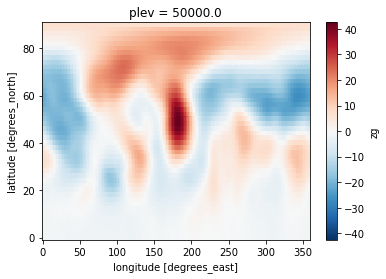

In [8]:
# Composite of WFD
# Get Composite anomoaly for fog days
wfdComp=wfdZ.mean(dim="time")
wfdComp.plot()

In [9]:
wfdZComp_cube=wfdComp.to_iris()
wfdZComp_cube
wfdZComp_cube_small=wfdComp.sel(latitude=slice(50,0),longitude=slice(30,120)).to_iris()
wfdZComp_cube_small

<iris 'Cube' of zg / (unknown) (latitude: 26; longitude: 46)>

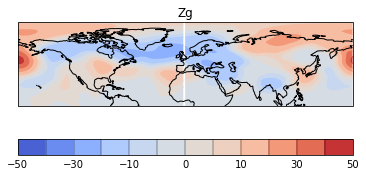

In [10]:
levels = (-50,-40,-30,-20,-10, -5,0,5,10,20,30,40,50)

qplt.contourf(wfdZComp_cube,cmap='coolwarm',levels=levels)

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

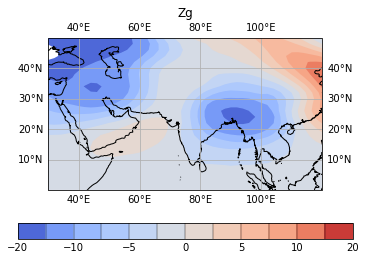

In [11]:
levels = (-20,-15,-10,-7.5,-5, -2.5,0,2.5,5,7.5,10,15,20)

qplt.contourf(wfdZComp_cube_small, cmap='coolwarm',levels=levels)

#qplt.contourf(wfdZComp_cube, brewer_cmap.N, cmap=brewer_cmap,levels=levels)

# Add coastlines to the map created by contourf.
plt.gca().coastlines()
plt.gca().gridlines(draw_labels=True)

plt.show()

# Positive Anomalies 

In [12]:
zwidePos=wfdZ.where(wfdZ.sel(latitude=slice(40,20),longitude=slice(60,85)).mean(dim=['latitude','longitude']) > 0.0, drop=True)
PosCnt=zwidePos.time.sizes
print(PosCnt)
zwidePosComp=zwidePos.mean(dim="time")

Frozen({'time': 125})


In [13]:
zwidePosComp_cube=zwidePosComp.to_iris()
zwidePosComp_cube
zwidePosComp_cube_small=zwidePosComp.sel(latitude=slice(50,0),longitude=slice(30,120)).to_iris()
zwidePosComp_cube_small

<iris 'Cube' of zg / (unknown) (latitude: 26; longitude: 46)>

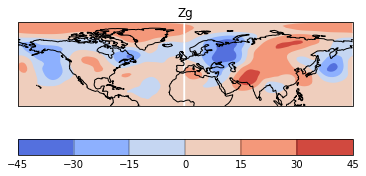

In [14]:
qplt.contourf(zwidePosComp_cube,cmap='coolwarm')

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

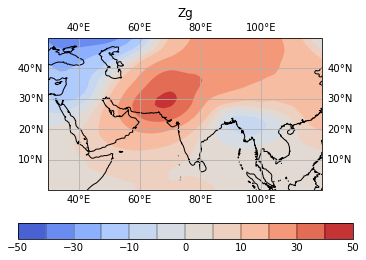

In [15]:
levels = (-50,-40,-30,-20,-10, -5,0,5,10,20,30,40,50)

qplt.contourf(zwidePosComp_cube_small, cmap='coolwarm',levels=levels)

#qplt.contourf(wfdZComp_cube, brewer_cmap.N, cmap=brewer_cmap,levels=levels)

# Add coastlines to the map created by contourf.
plt.gca().coastlines()
plt.gca().gridlines(draw_labels=True)

# Negative Anomalies 

In [16]:
zwideNeg=wfdZ.where(wfdZ.sel(latitude=slice(40,20),longitude=slice(60,85)).mean(dim=['latitude','longitude']) < 0.0, drop=True)
NegCnt=zwideNeg.time.sizes
print(NegCnt)
zwideNegComp=zwideNeg.mean(dim="time")

Frozen({'time': 176})


In [17]:
zwideNegComp_cube=zwideNegComp.to_iris()
zwideNegComp_cube
zwideNegComp_cube_small=zwideNegComp.sel(latitude=slice(50,0),longitude=slice(30,120)).to_iris()
zwideNegComp_cube_small

<iris 'Cube' of zg / (unknown) (latitude: 26; longitude: 46)>

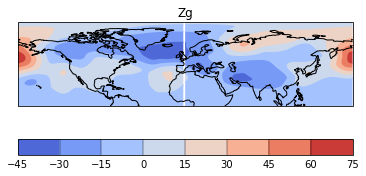

In [18]:
qplt.contourf(zwideNegComp_cube,cmap='coolwarm')

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

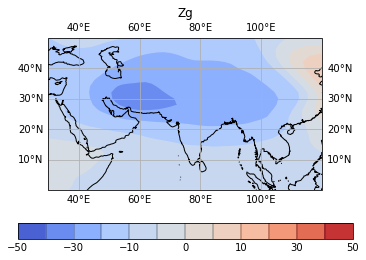

In [19]:
levels = (-50,-40,-30,-20,-10, -5,0,5,10,20,30,40,50)

qplt.contourf(zwideNegComp_cube_small, cmap='coolwarm',levels=levels)

#qplt.contourf(wfdZComp_cube, brewer_cmap.N, cmap=brewer_cmap,levels=levels)

# Add coastlines to the map created by contourf.
plt.gca().coastlines()
plt.gca().gridlines(draw_labels=True)